<a href="https://colab.research.google.com/github/medayoubaziz/Car_insurance_predictions/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/Car_Insurance_Claim.csv'

car_df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax


In [4]:
def explore_num(inspection_df , x , figsize=(7.5)) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 nunique = temp_df[x].nunique()
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 gridspec = {'height_ratios':[0.7,0.3]}
 fig,ax = plt.subplots(nrows=2 , figsize=figsize , sharex=True , gridspec_kw=gridspec)
 sns.histplot(data=temp_df , x=x , ax= ax[0])
 sns.boxplot(data=temp_df , x=x , ax=ax[1])
 ax[0].set_title(f"Column: {x}", fontweight='bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 print(f'There is {nunique} unique values')
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax


In [5]:
car_df.info()
car_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


#1. Source of data

https://www.kaggle.com/

#2. Brief description of data

The data has 19 features from there 18 of them are corresponding logs which were taken by the company  to find out the real customer behaviors .

#3. What is the target?

Our target is the column : OUTCOME.

#4. What does one row represent? (A person? A business? An event? A product?)

Each row represent a person with a car .

#5. Is this a classification or regression problem?

This is a classification problem .

#6. How many features does the data have?

There is 18 feautres except our target .

#7. How many rows are in the dataset?

1000 rows .

#8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

I'm going to check for duplicated rows and the null values/missing data and explore them and then i'm going to check the balance of our target so it can help me with my model.

In [6]:
car_df.duplicated().sum()

0

In [7]:
car_df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

<Axes: >

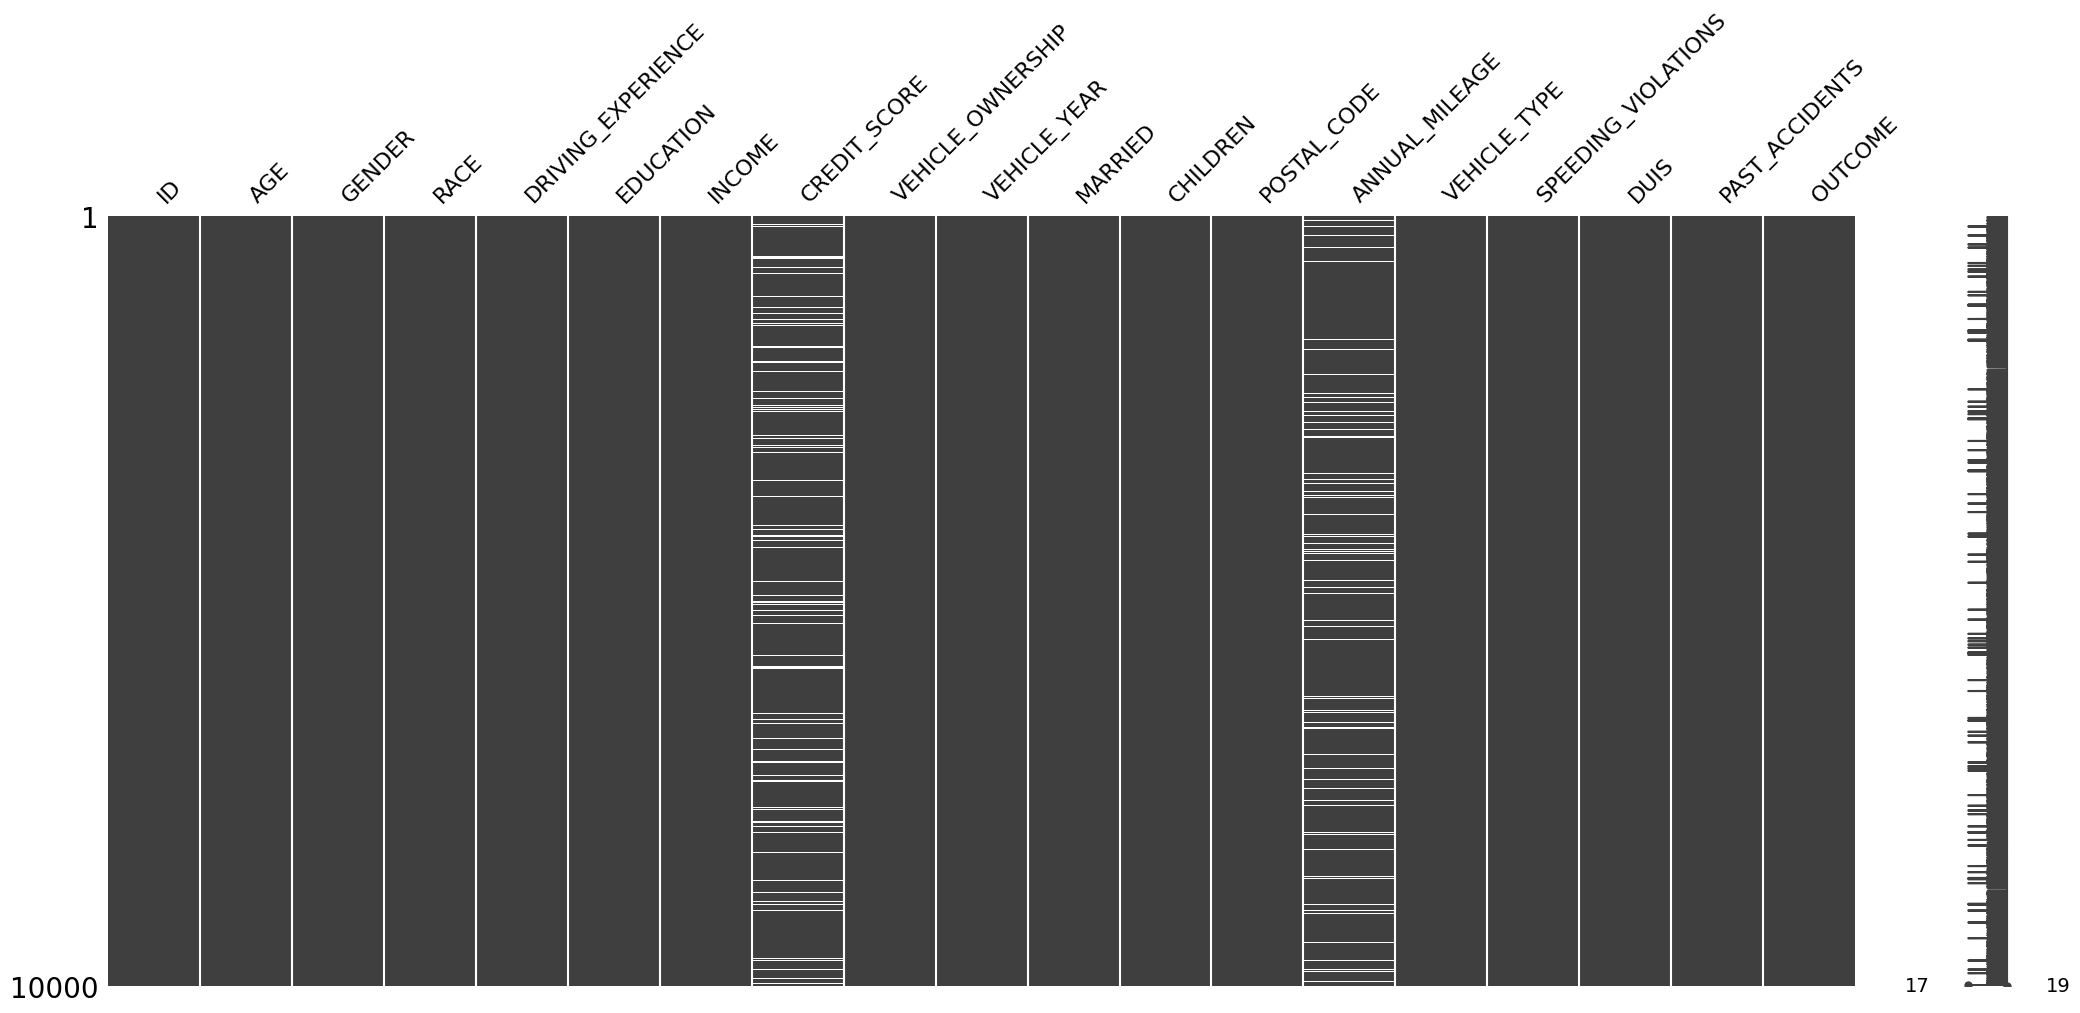

In [8]:
import missingno as msno
msno.matrix(car_df)

As we can see , there are two features with missing data : CREDIT_SCORE and ANNUAL_MILEAGE , the other features and the target dosen't have missig values .

In [9]:
car_df['ID'].value_counts().sum()/len(car_df)

1.0

In [10]:
#let's change the index of our data
car_df = car_df.set_index('ID')
car_df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [11]:
 car_df.select_dtypes('number').columns


Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

##Target column

In [12]:
car_df['OUTCOME'].value_counts(normalize=True)

0.0    0.6867
1.0    0.3133
Name: OUTCOME, dtype: float64

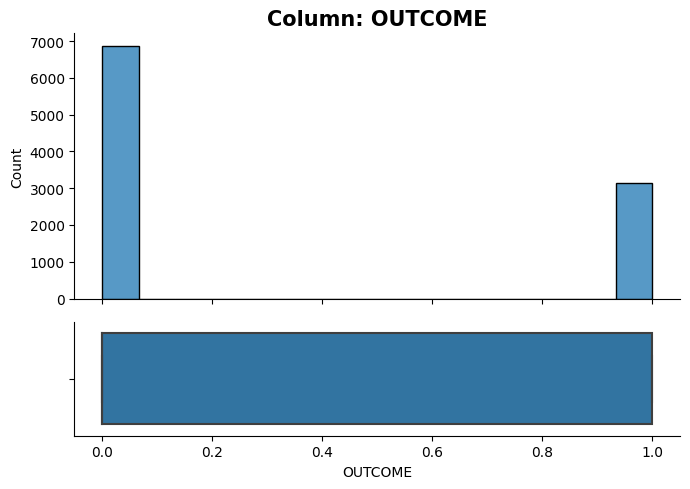

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0.0 , occurs 6867 times (68.67%)
OUTCOME: is neither constant or a quasi-constant feauture and should be kept


In [13]:
explore_num(car_df,'OUTCOME',figsize=(7,5));

##CREDIT_SCORE column

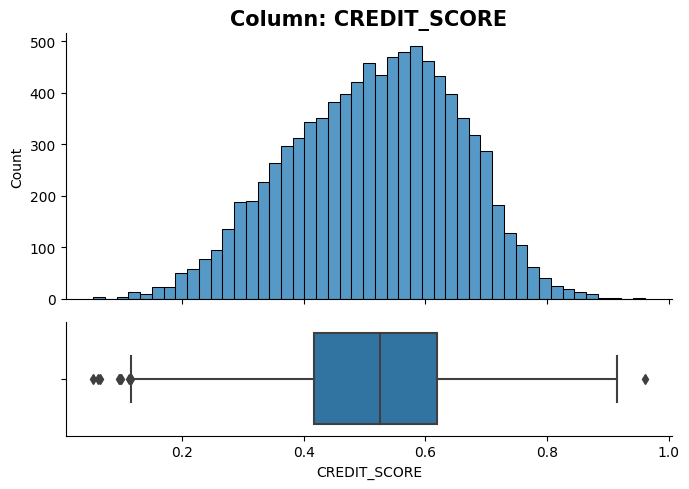

There is 982 NaN (9.82%)
There is 9018 unique values
The most common value is nan , occurs 982 times (9.82%)
CREDIT_SCORE: is neither constant or a quasi-constant feauture and should be kept


In [14]:
explore_num(car_df,'CREDIT_SCORE',figsize=(7,5));

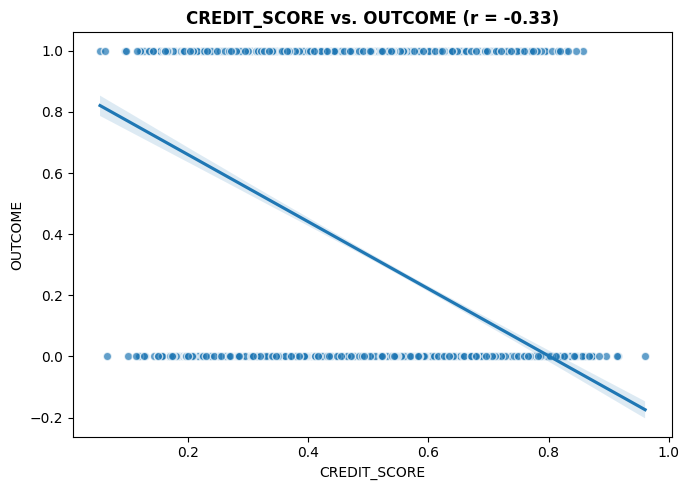

In [15]:
target = 'OUTCOME'
plot_num_vs_target(car_df,x='CREDIT_SCORE',y=target);

CREDIT_SCORE is a numerical feature with 9.82% of missing values , for the imputation i'm going to use median as a strategy.

##VEHICLE_OWNERSHIP column

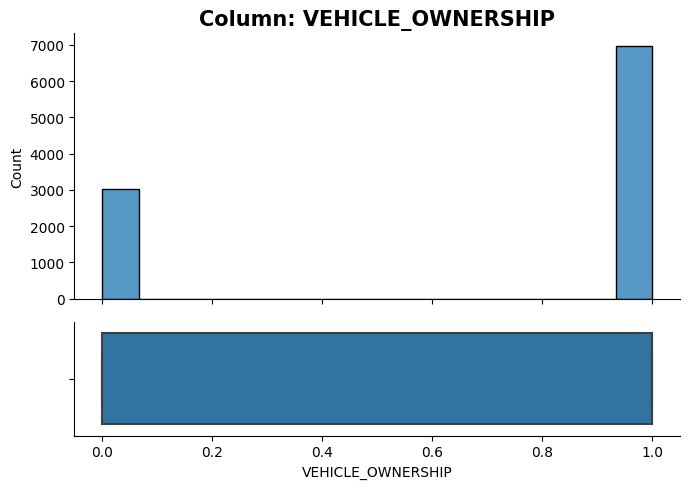

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 1.0 , occurs 6970 times (69.7%)
VEHICLE_OWNERSHIP: is neither constant or a quasi-constant feauture and should be kept


In [16]:
explore_num(car_df,'VEHICLE_OWNERSHIP',figsize=(7,5));

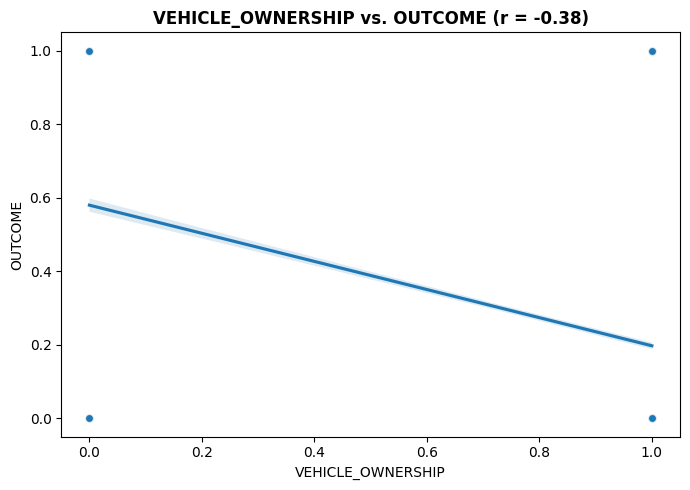

In [17]:
plot_num_vs_target(car_df,'VEHICLE_OWNERSHIP',y=target);

##MARRIED column

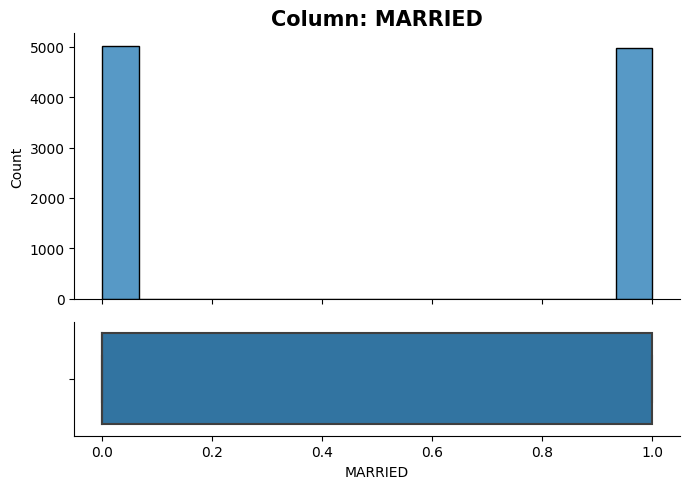

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0.0 , occurs 5018 times (50.18%)
MARRIED: is neither constant or a quasi-constant feauture and should be kept


In [18]:
explore_num(car_df,'MARRIED',figsize=(7,5));

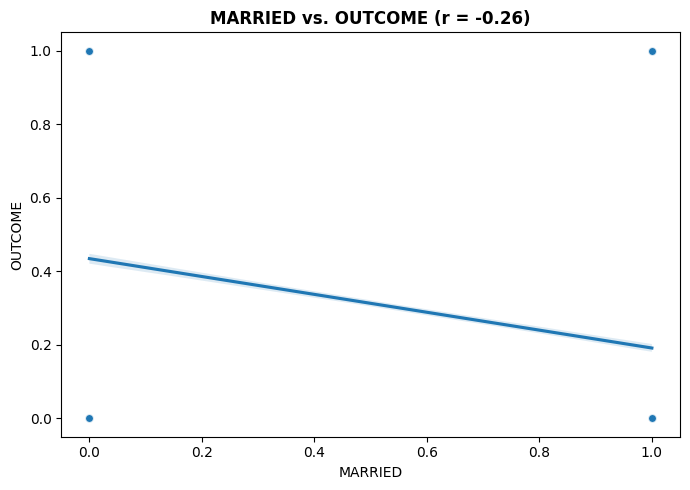

In [19]:
plot_num_vs_target(car_df,'MARRIED',y=target);

##CHILDREN column

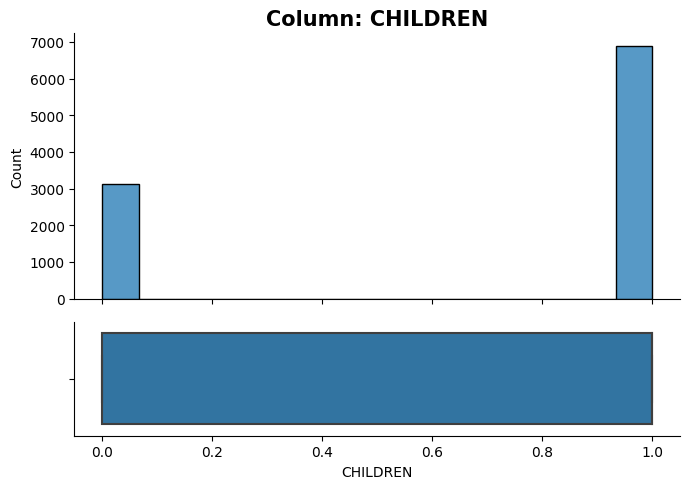

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 1.0 , occurs 6888 times (68.88%)
CHILDREN: is neither constant or a quasi-constant feauture and should be kept


In [20]:
explore_num(car_df,'CHILDREN',figsize=(7,5));

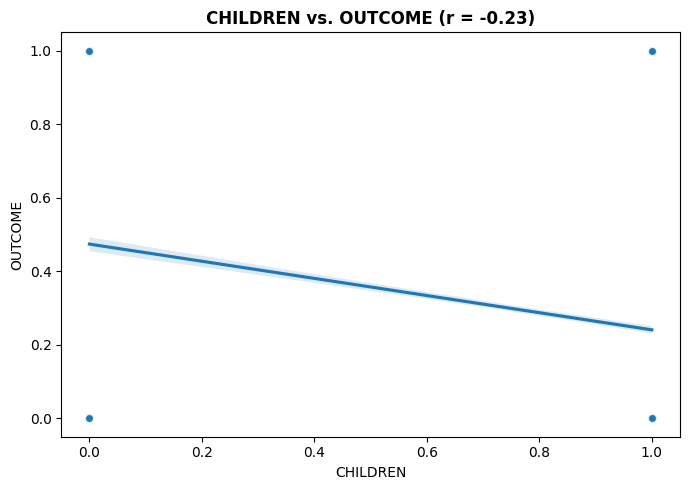

In [21]:
plot_num_vs_target(car_df,'CHILDREN',y=target);

##POSTAL_CODE column

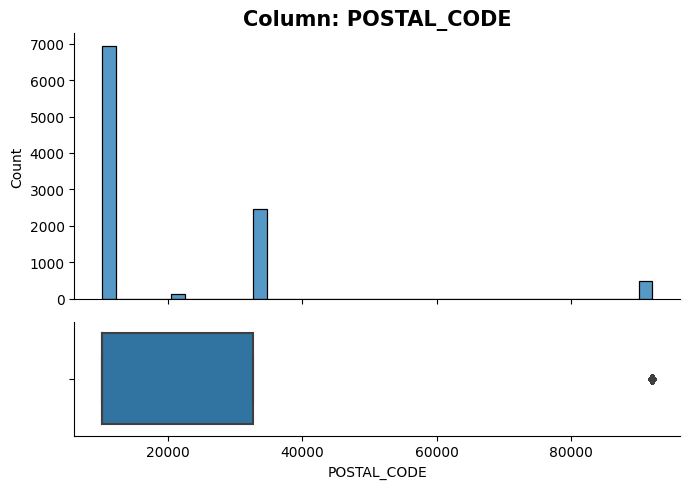

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 10238 , occurs 6940 times (69.4%)
POSTAL_CODE: is neither constant or a quasi-constant feauture and should be kept


In [22]:
explore_num(car_df,'POSTAL_CODE',figsize=(7,5));

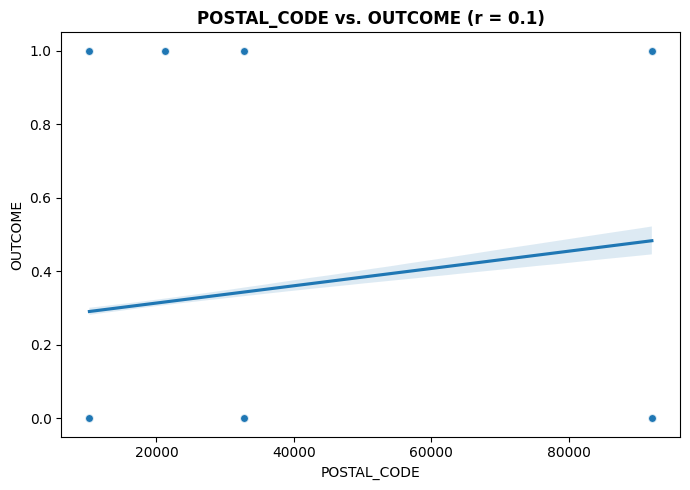

In [23]:
plot_num_vs_target(car_df,'POSTAL_CODE',y=target);

##ANNUAL_MILEAGE column

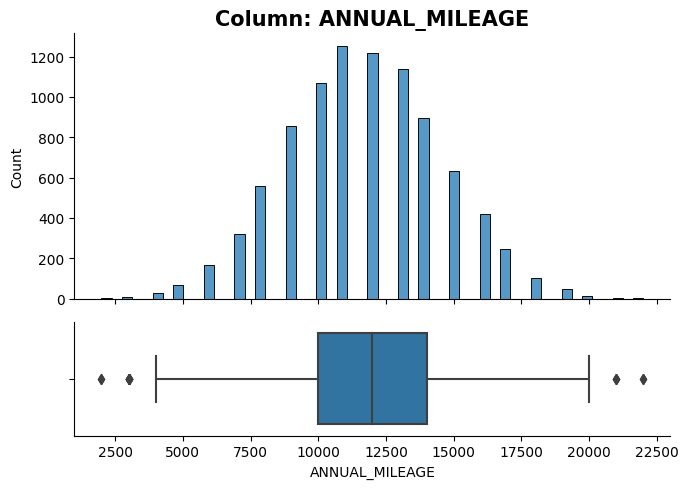

There is 957 NaN (9.57%)
There is 21 unique values
The most common value is 11000.0 , occurs 1253 times (12.53%)
ANNUAL_MILEAGE: is neither constant or a quasi-constant feauture and should be kept


In [24]:
explore_num(car_df,'ANNUAL_MILEAGE',figsize=(7,5));

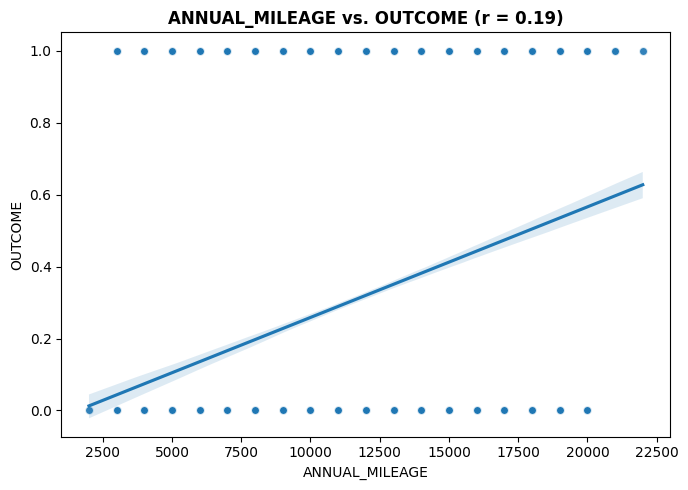

In [25]:
plot_num_vs_target(car_df,'ANNUAL_MILEAGE',y=target);

The ANNUAL_MILEAGE column is a numerical feature with 9.57% of missing values so i'm going to impute with the median as a strategy.

##SPEEDING_VIOLATIONS column

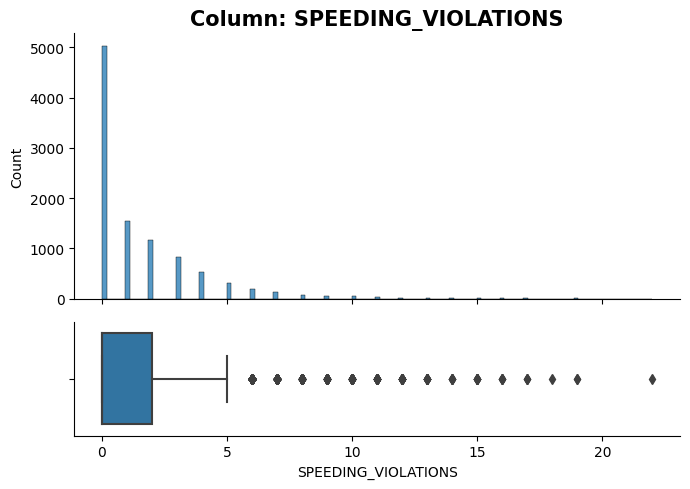

There is 0 NaN (0.0%)
There is 21 unique values
The most common value is 0 , occurs 5028 times (50.28%)
SPEEDING_VIOLATIONS: is neither constant or a quasi-constant feauture and should be kept


In [26]:
explore_num(car_df,'SPEEDING_VIOLATIONS',figsize=(7,5));

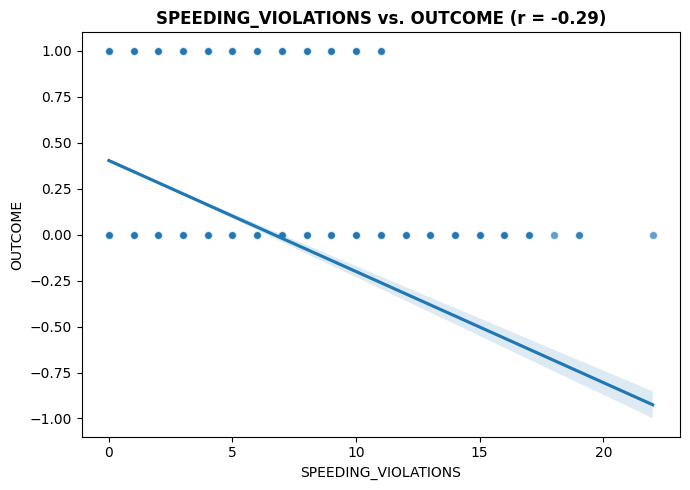

In [27]:
plot_num_vs_target(car_df,'SPEEDING_VIOLATIONS',y=target);

##DUIS column

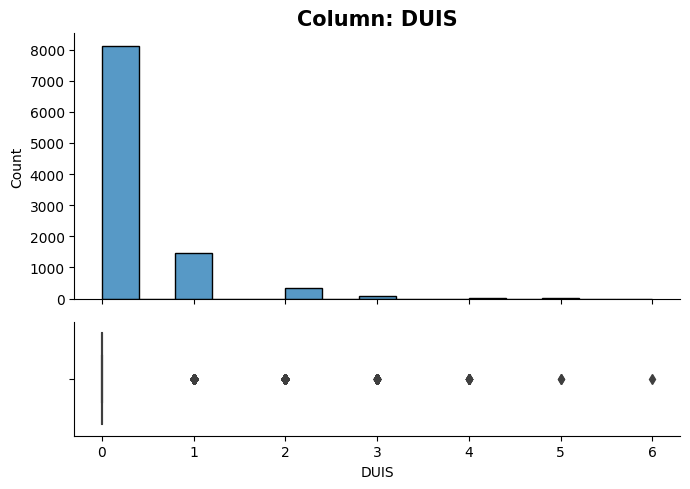

There is 0 NaN (0.0%)
There is 7 unique values
The most common value is 0 , occurs 8118 times (81.18%)
DUIS: is neither constant or a quasi-constant feauture and should be kept


In [28]:
explore_num(car_df,'DUIS',figsize=(7,5));

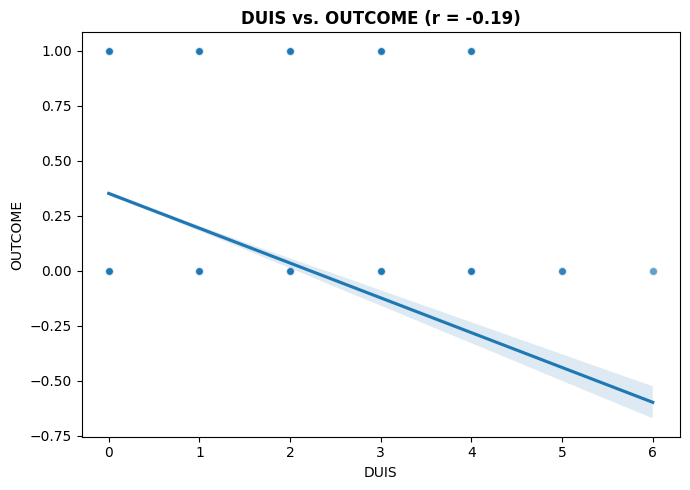

In [29]:
plot_num_vs_target(car_df,'DUIS',y=target);

##PAST_ACCIDENTS column

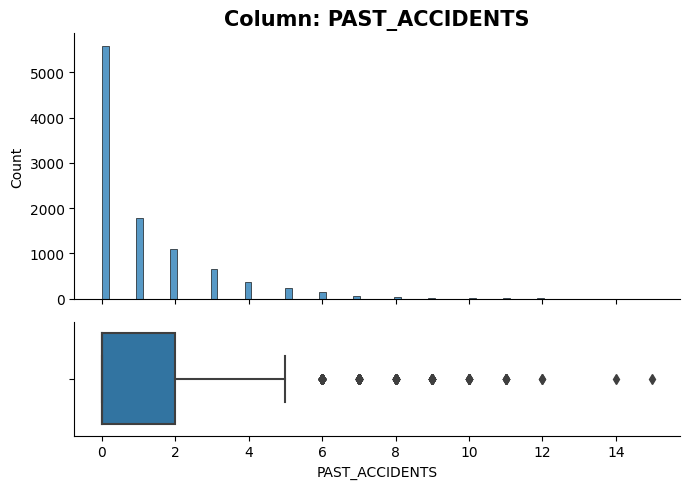

There is 0 NaN (0.0%)
There is 15 unique values
The most common value is 0 , occurs 5584 times (55.84%)
PAST_ACCIDENTS: is neither constant or a quasi-constant feauture and should be kept


In [30]:
explore_num(car_df,'PAST_ACCIDENTS',figsize=(7,5));

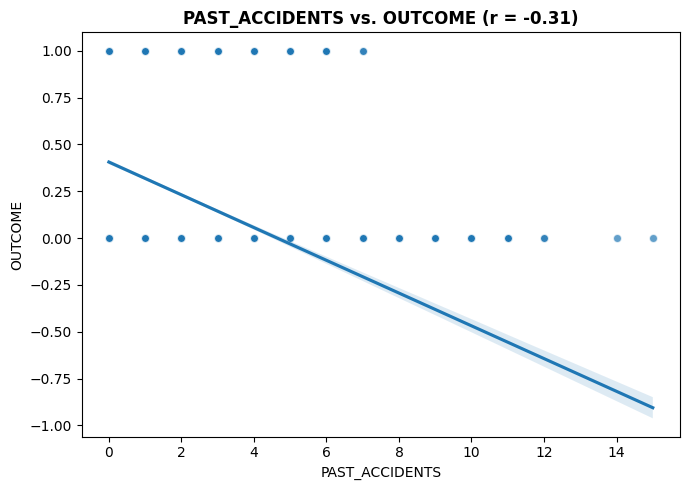

In [31]:
plot_num_vs_target(car_df,'PAST_ACCIDENTS',y=target);

<Axes: >

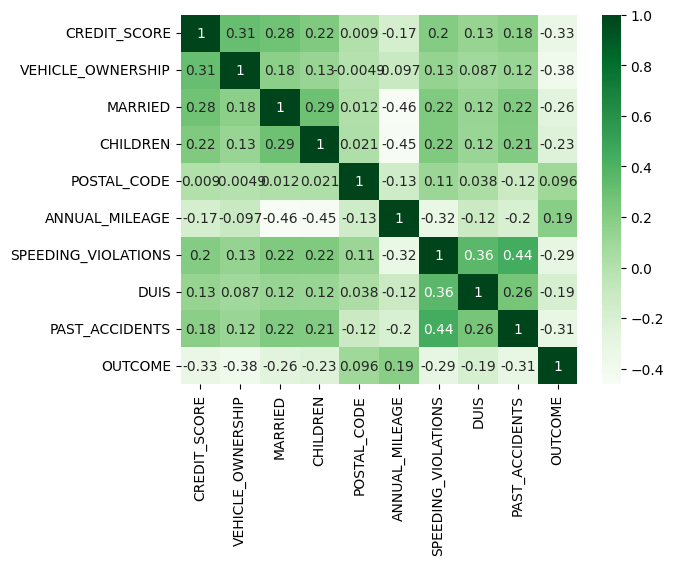

In [32]:
corr = car_df.corr()
sns.heatmap(corr, cmap = 'Greens' , annot=True)


In [33]:
car_df.describe().round(2)

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.00,10000.00,10000.0,10000.00,10000.00,9043.00,10000.00,10000.00,10000.00,10000.00
mean,0.52,0.70,0.5,0.69,19864.55,11697.00,1.48,0.24,1.06,0.31
std,0.14,0.46,0.5,0.46,18915.61,2818.43,2.24,0.55,1.65,0.46
min,0.05,0.00,0.0,0.00,10238.00,2000.00,0.00,0.00,0.00,0.00
25%,0.42,0.00,0.0,0.00,10238.00,10000.00,0.00,0.00,0.00,0.00
50%,0.53,1.00,0.0,1.00,10238.00,12000.00,0.00,0.00,0.00,0.00
75%,0.62,1.00,1.0,1.00,32765.00,14000.00,2.00,0.00,2.00,1.00
max,0.96,1.00,1.0,1.00,92101.00,22000.00,22.00,6.00,15.00,1.00


In [34]:
car_df.select_dtypes('object').columns

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')

##AGE column

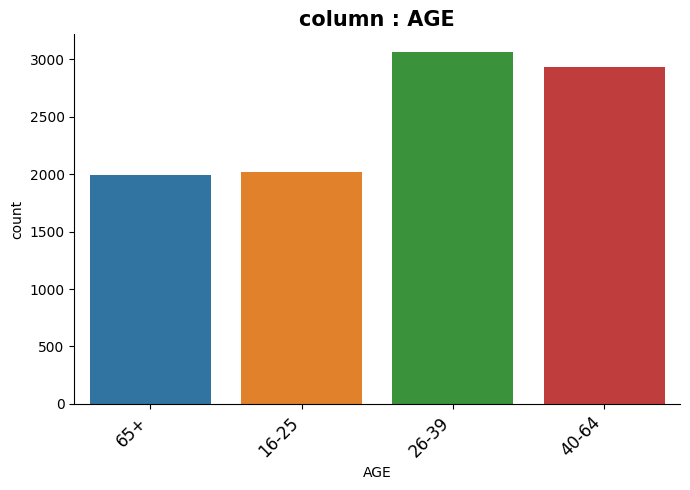

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 26-39 , occurs 3063 times (30.63%)
AGE: is neither constant or a quasi-constant feauture and should be kept


In [35]:
explore_cat(car_df,'AGE');

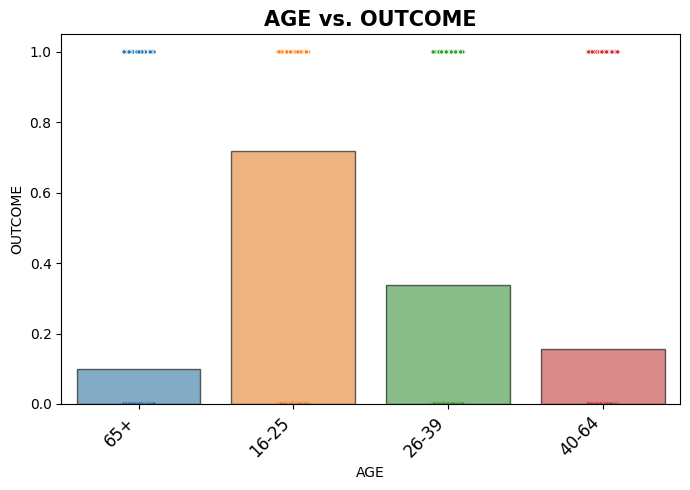

In [36]:
plot_cat_vs_target(car_df,'AGE',y=target);

##GENDER column

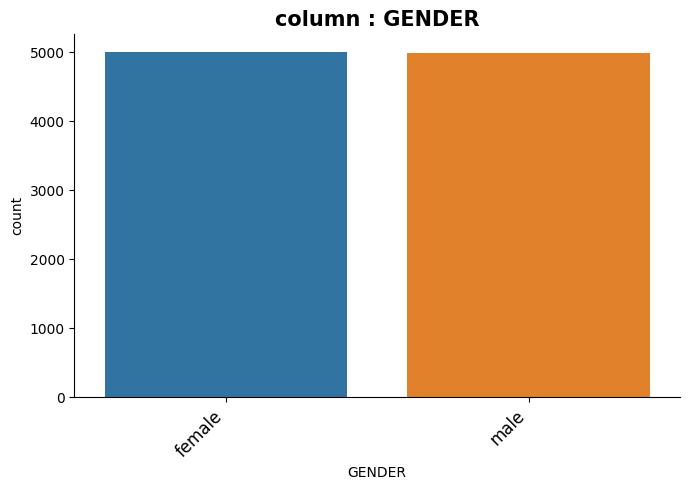

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is female , occurs 5010 times (50.1%)
GENDER: is neither constant or a quasi-constant feauture and should be kept


In [37]:
explore_cat(car_df,'GENDER');

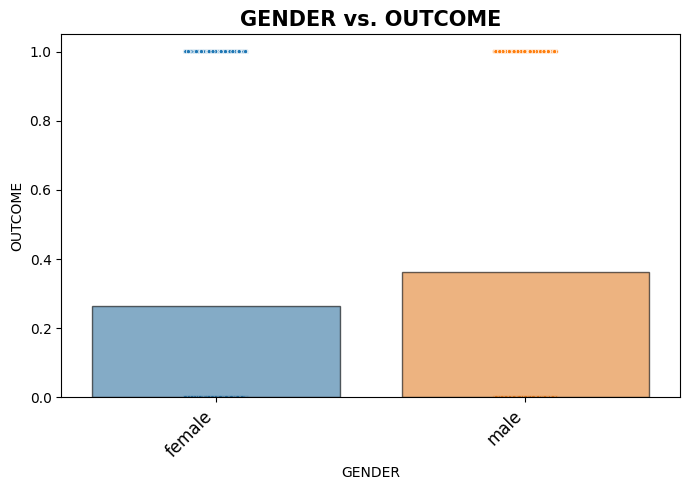

In [38]:
plot_cat_vs_target(car_df,'GENDER',y=target);

##RACE column

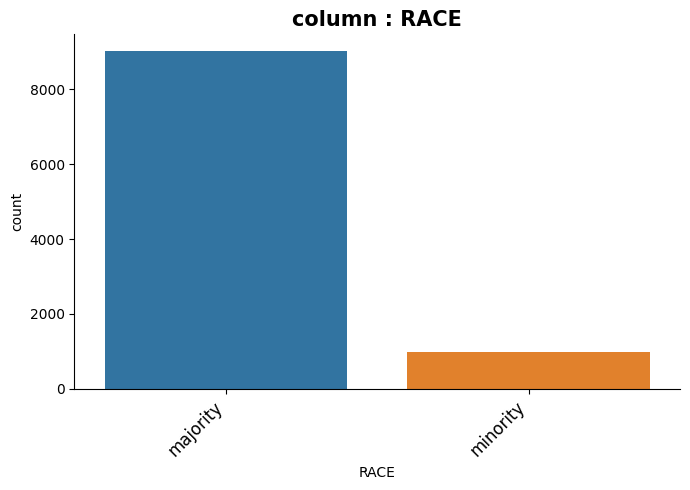

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is majority , occurs 9012 times (90.12%)
RACE: is neither constant or a quasi-constant feauture and should be kept


In [39]:
explore_cat(car_df,'RACE');

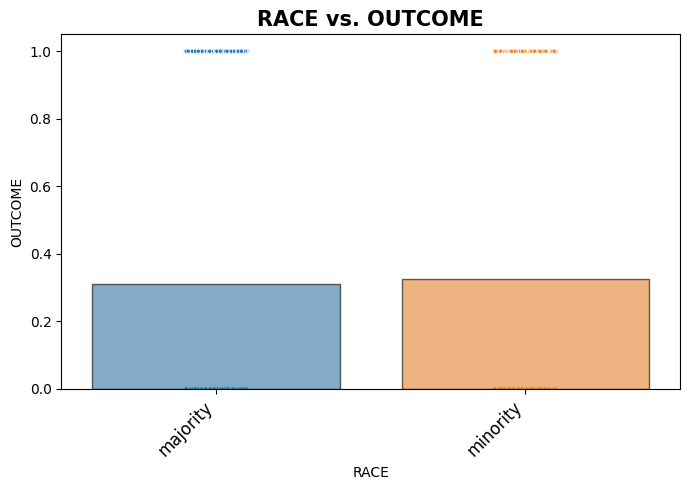

In [40]:
plot_cat_vs_target(car_df,'RACE',y=target);

##DRIVING_EXPERIENCE column

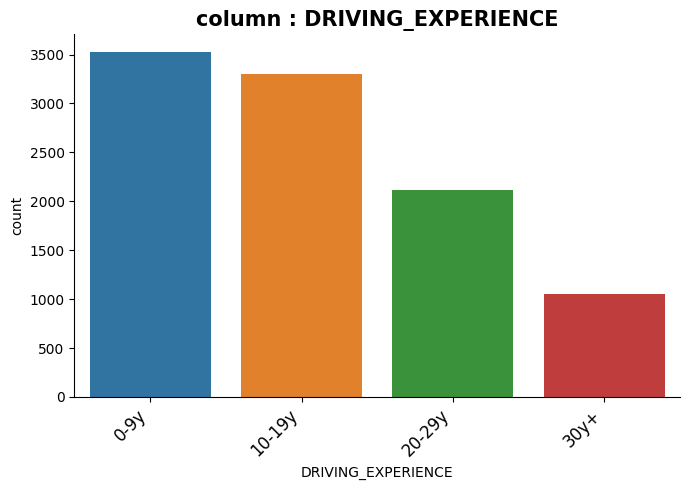

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 0-9y , occurs 3530 times (35.3%)
DRIVING_EXPERIENCE: is neither constant or a quasi-constant feauture and should be kept


In [41]:
explore_cat(car_df,'DRIVING_EXPERIENCE');

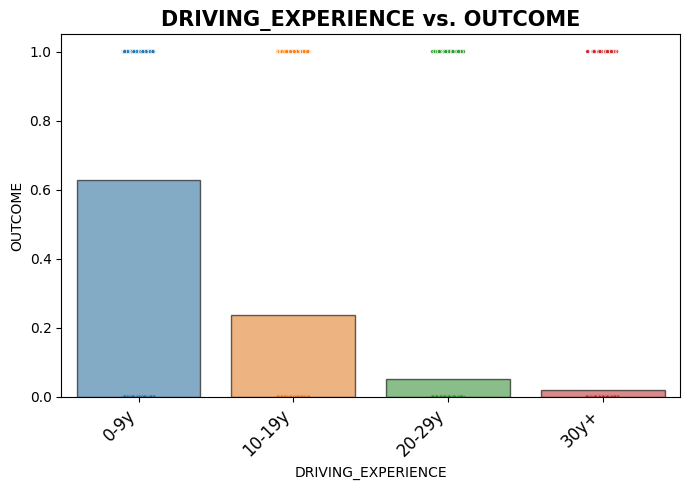

In [42]:
plot_cat_vs_target(car_df,'DRIVING_EXPERIENCE',y=target);

##EDUCATION column

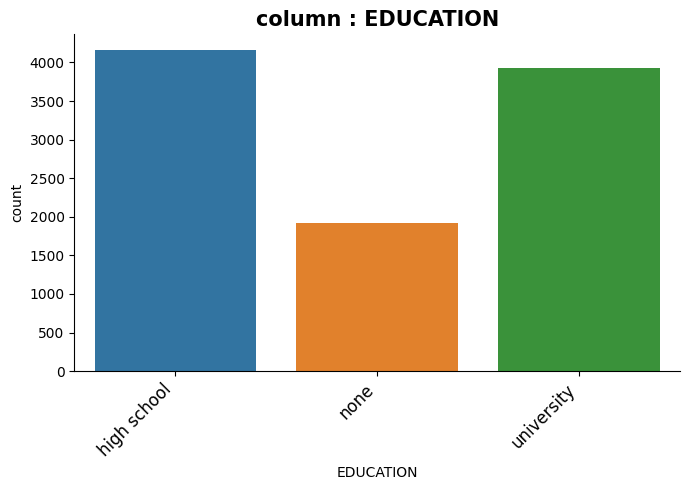

There is 0 NaN (0.0%)
There is 3 unique values
The most common value is high school , occurs 4157 times (41.57%)
EDUCATION: is neither constant or a quasi-constant feauture and should be kept


In [43]:
explore_cat(car_df,'EDUCATION');

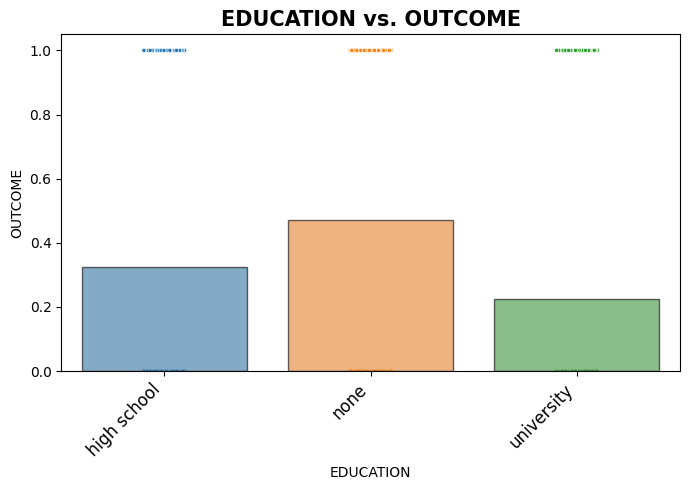

In [44]:
plot_cat_vs_target(car_df,'EDUCATION',y=target);

##INCOME column

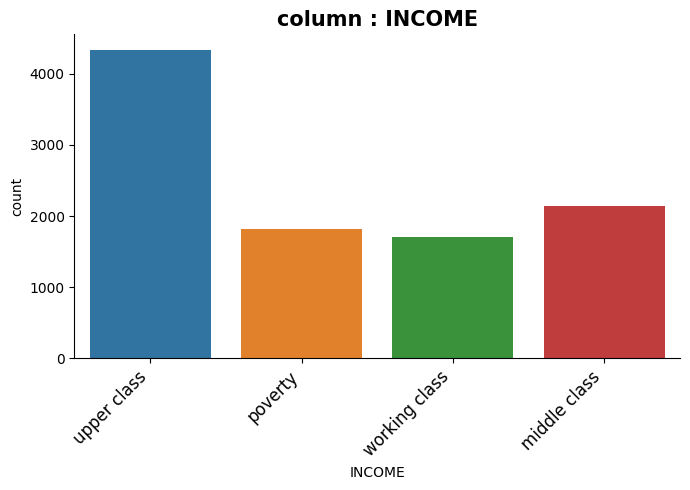

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is upper class , occurs 4336 times (43.36%)
INCOME: is neither constant or a quasi-constant feauture and should be kept


In [45]:
explore_cat(car_df,'INCOME');

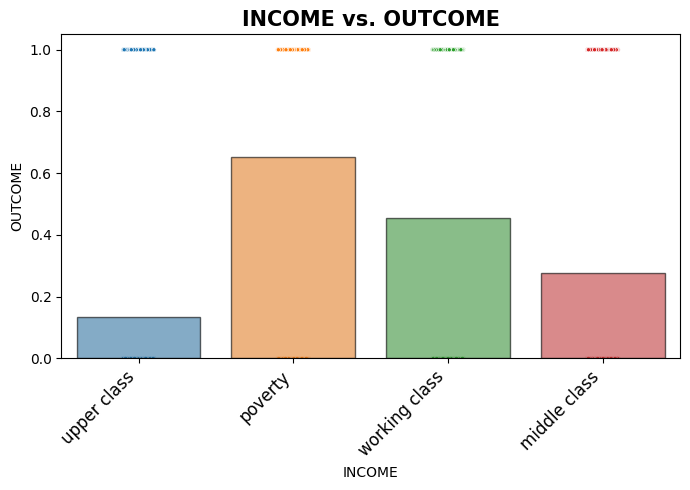

In [46]:
plot_cat_vs_target(car_df,'INCOME',y=target);

##VEHICLE_YEAR column

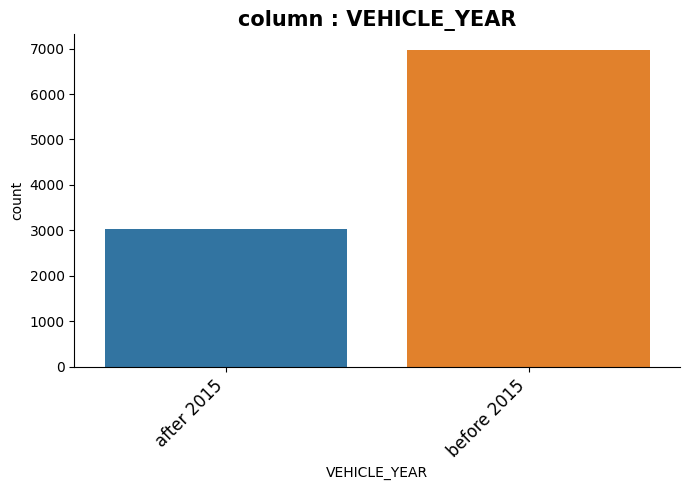

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is before 2015 , occurs 6967 times (69.67%)
VEHICLE_YEAR: is neither constant or a quasi-constant feauture and should be kept


In [47]:
explore_cat(car_df,'VEHICLE_YEAR');

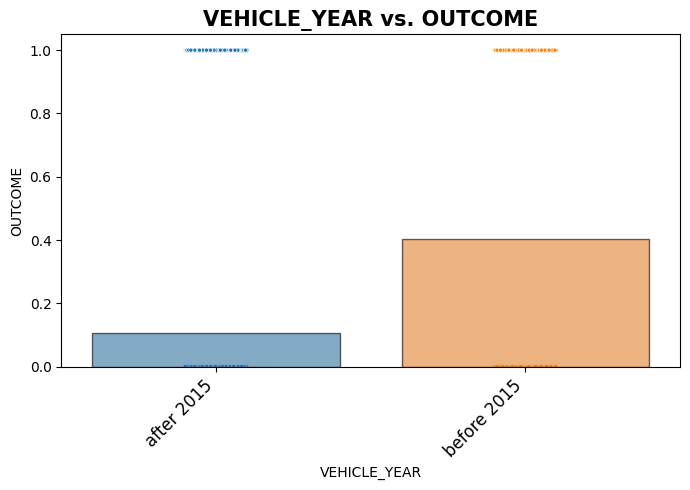

In [48]:
plot_cat_vs_target(car_df,'VEHICLE_YEAR',y=target);

##VEHICLE_TYPE column

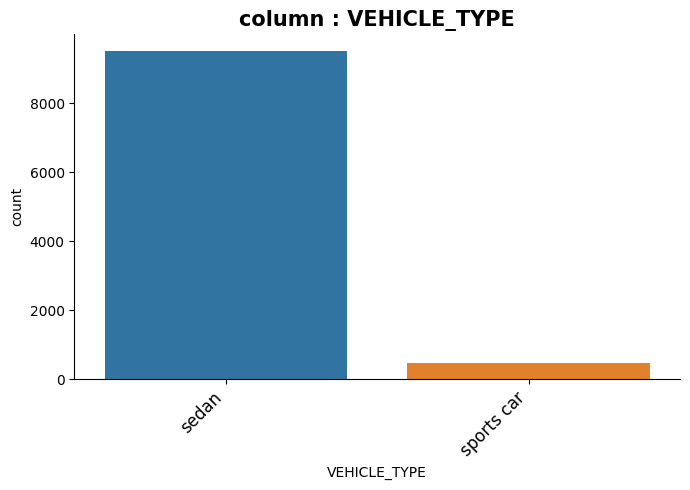

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is sedan , occurs 9523 times (95.23%)
VEHICLE_TYPE: is neither constant or a quasi-constant feauture and should be kept


In [49]:
explore_cat(car_df,'VEHICLE_TYPE');

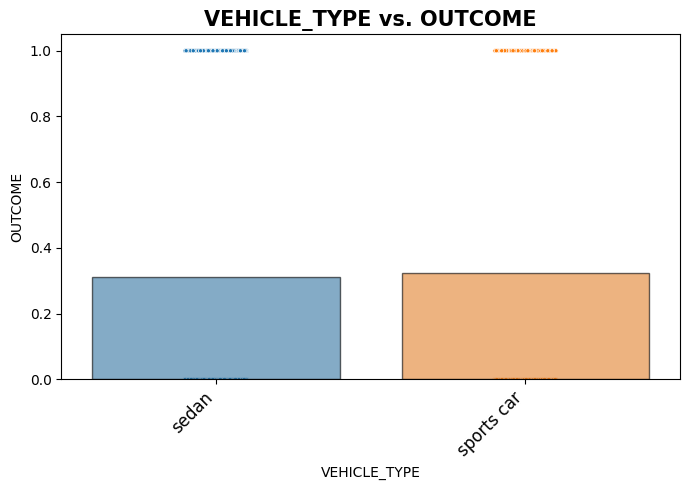

In [50]:
plot_cat_vs_target(car_df,'VEHICLE_TYPE',y=target);

In [51]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non

In [52]:
# i will impute the missing data after splitting the data to not have to deal with data leakage .
X = car_df.drop('OUTCOME',axis=1)
y = car_df['OUTCOME']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=420)
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [53]:
from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer([('num',num_imputer,X_train.select_dtypes('number').columns),('cat',ohe,X_train.select_dtypes('object').columns)],verbose_feature_names_out=False)

In [54]:
X_train = transformer.fit_transform(X_train)

In [55]:
X_test = transformer.fit_transform(X_test)

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 540695 to 85611
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CREDIT_SCORE               7500 non-null   float64
 1   VEHICLE_OWNERSHIP          7500 non-null   float64
 2   MARRIED                    7500 non-null   float64
 3   CHILDREN                   7500 non-null   float64
 4   POSTAL_CODE                7500 non-null   float64
 5   ANNUAL_MILEAGE             7500 non-null   float64
 6   SPEEDING_VIOLATIONS        7500 non-null   float64
 7   DUIS                       7500 non-null   float64
 8   PAST_ACCIDENTS             7500 non-null   float64
 9   AGE_16-25                  7500 non-null   float64
 10  AGE_26-39                  7500 non-null   float64
 11  AGE_40-64                  7500 non-null   float64
 12  AGE_65+                    7500 non-null   float64
 13  GENDER_female              7500 non-null  

In [57]:
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3 = LogisticRegression()
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# Model1 :

In [58]:
model1.fit(X_train,y_train)

DecisionTreeClassifier()

In [59]:
model1_train_preds = model1.predict(X_train)
model1_test_preds = model1.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,model1_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,model1_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5124
         1.0       1.00      1.00      1.00      2376

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      1743
         1.0       0.67      0.69      0.68       757

    accuracy                           0.80      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.80      0.80      0.80      2500



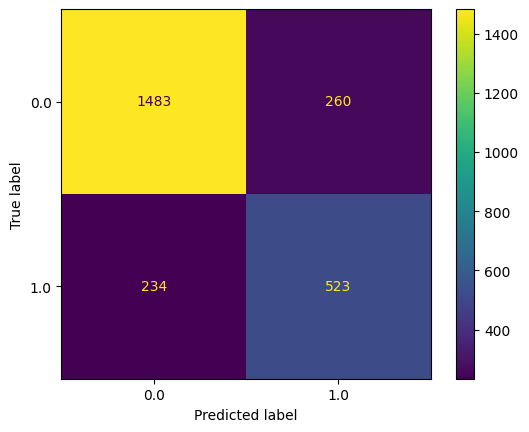

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test,model1_test_preds)

In [61]:
model1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [62]:
model1_params = {'max_depth': [None,2,3,5,7,10],
               'criterion': ['gini','entropy','log_loss']}
model1_grid = GridSearchCV(model1,model1_params)
model1_grid.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 2, 3, 5, 7, 10]})

In [63]:
best_model1 = model1_grid.best_estimator_
best_model1_train_preds = best_model1.predict(X_train)
best_model1_test_preds = best_model1.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,best_model1_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_model1_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      5124
         1.0       0.81      0.68      0.74      2376

    accuracy                           0.85      7500
   macro avg       0.84      0.80      0.81      7500
weighted avg       0.84      0.85      0.84      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      1743
         1.0       0.78      0.69      0.73       757

    accuracy                           0.85      2500
   macro avg       0.83      0.80      0.81      2500
weighted avg       0.84      0.85      0.84      2500



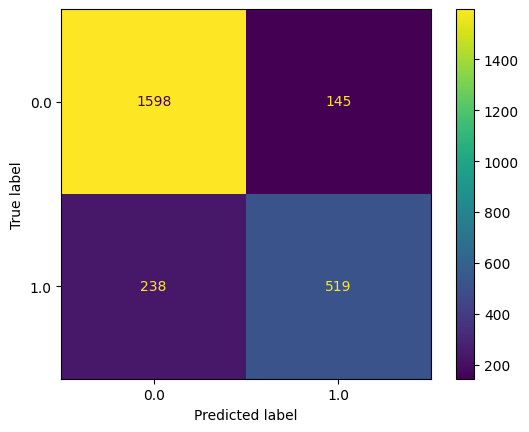

In [64]:
ConfusionMatrixDisplay.from_predictions(y_test,best_model1_test_preds)

In [65]:
# i will try the same model but with the data transformed with pca .
model11 = DecisionTreeClassifier()
model11.fit(X_train_pca,y_train)
pca_train_preds = model11.predict(X_train_pca)
pca_test_preds = model11.predict(X_test_pca)
print("The classification report of the train set :")
print(classification_report(y_train,pca_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,pca_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81      5124
         1.0       0.61      0.20      0.30      2376

    accuracy                           0.71      7500
   macro avg       0.66      0.57      0.56      7500
weighted avg       0.68      0.71      0.65      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83      1743
         1.0       1.00      0.04      0.08       757

    accuracy                           0.71      2500
   macro avg       0.85      0.52      0.45      2500
weighted avg       0.79      0.71      0.60      2500



In [66]:
model11_params = {'max_depth': [None,2,3,5,7,10],
               'criterion': ['gini','entropy','log_loss']}
model11_grid = GridSearchCV(model11,model11_params)
model11_grid.fit(X_train_pca,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 2, 3, 5, 7, 10]})

In [67]:
best_model11 = model11_grid.best_estimator_
best_pca_train_preds = best_model11.predict(X_train_pca)
best_pca_test_preds = best_model11.predict(X_test_pca)
print("The classification report of the train set :")
print(classification_report(y_train,best_pca_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_pca_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81      5124
         1.0       0.62      0.17      0.27      2376

    accuracy                           0.70      7500
   macro avg       0.66      0.56      0.54      7500
weighted avg       0.68      0.70      0.64      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83      1743
         1.0       1.00      0.04      0.08       757

    accuracy                           0.71      2500
   macro avg       0.85      0.52      0.45      2500
weighted avg       0.79      0.71      0.60      2500



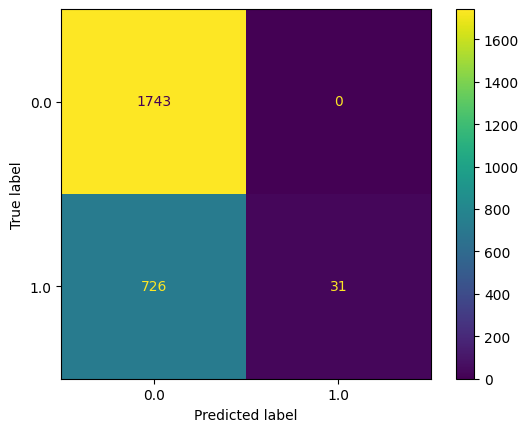

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test,best_pca_test_preds)

For this first model i used the Decision Tree Classifier :

After tuning with GridSearchCV the result was : F_score(0.89/0.73) , Recall(0.92/0.69) and with 0.85 as accuracy

With PCA the model didn't have a good performance with 0.71 as accuracy .

# Model2:

In [69]:
model2.fit(X_train,y_train)

KNeighborsClassifier()

In [70]:
model2_train_preds = model2.predict(X_train)
model2_test_preds = model2.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,model2_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,model2_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      5124
         1.0       0.79      0.78      0.79      2376

    accuracy                           0.87      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.86      0.87      0.86      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1743
         1.0       0.67      0.68      0.68       757

    accuracy                           0.80      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.80      0.80      0.80      2500



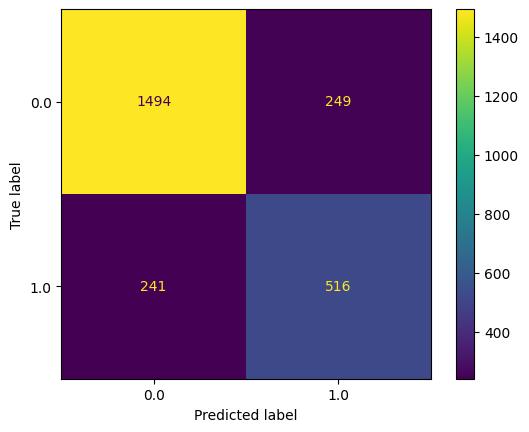

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test,model2_test_preds)

In [72]:
model2.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [73]:
model2_params = {'n_neighbors': [2,3,5,7],
                 'p': [1,2],
                 'algorithm': ['auto','ball_tree','kd_tree','brute']}
model2_grid = GridSearchCV(model2,model2_params)
model2_grid.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 5, 7], 'p': [1, 2]})

In [74]:
best_model2 = model2_grid.best_estimator_
best_model2_train_preds = best_model2.predict(X_train)
best_model2_test_preds = best_model2.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,best_model2_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_model2_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      5124
         1.0       0.77      0.76      0.77      2376

    accuracy                           0.85      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.85      0.85      0.85      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      1743
         1.0       0.69      0.71      0.70       757

    accuracy                           0.82      2500
   macro avg       0.78      0.79      0.78      2500
weighted avg       0.82      0.82      0.82      2500



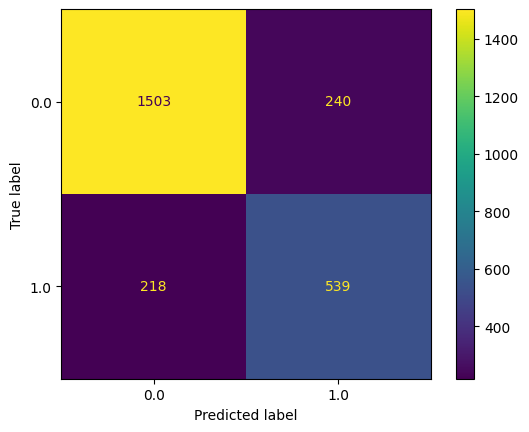

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test,best_model2_test_preds)

In [76]:
# i will try the same model but with the data transformed with pca .
model22 = KNeighborsClassifier()
model22.fit(X_train_pca,y_train)
pca2_train_preds = model22.predict(X_train_pca)
pca2_test_preds = model22.predict(X_test_pca)
print("The classification report of the train set :")
print(classification_report(y_train,pca2_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,pca2_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      5124
         1.0       0.73      0.66      0.69      2376

    accuracy                           0.82      7500
   macro avg       0.79      0.77      0.78      7500
weighted avg       0.81      0.82      0.81      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83      1743
         1.0       1.00      0.04      0.08       757

    accuracy                           0.71      2500
   macro avg       0.85      0.52      0.45      2500
weighted avg       0.79      0.71      0.60      2500



In [77]:
model22_params = {'n_neighbors': [2,3,5,7],
                 'p': [1,2],
                 'algorithm': ['auto','ball_tree','kd_tree','brute']}
model22_grid = GridSearchCV(model22,model22_params)
model22_grid.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 5, 7], 'p': [1, 2]})

In [78]:
best_model22 = model22_grid.best_estimator_
best_model22_train_preds = best_model22.predict(X_train)
best_model22_test_preds = best_model22.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,best_model22_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_model22_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      5124
         1.0       0.77      0.76      0.77      2376

    accuracy                           0.85      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.85      0.85      0.85      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      1743
         1.0       0.69      0.71      0.70       757

    accuracy                           0.82      2500
   macro avg       0.78      0.79      0.78      2500
weighted avg       0.82      0.82      0.82      2500



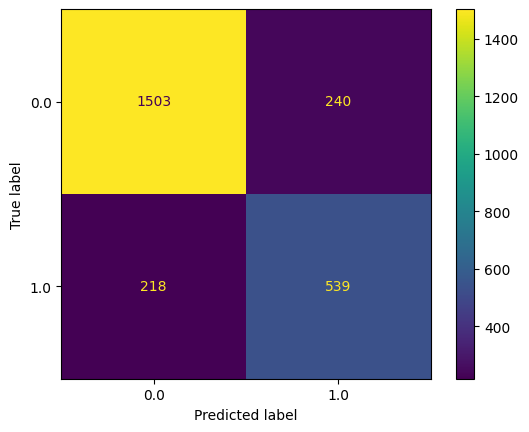

In [79]:
ConfusionMatrixDisplay.from_predictions(y_test,best_model22_test_preds)

For this second model i used the KNN :

After tuning with GridSearchCV the result was : F_score(0.87/0.7) , Recall(0.86/0.71) and with 0.82 as accuracy

With PCA the model had the same performance with the same accuracy.

# Model3:

In [80]:
model3.fit(X_train,y_train)

LogisticRegression()

In [81]:
model3_train_preds = model3.predict(X_train)
model3_test_preds = model3.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,model3_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,model3_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      5124
         1.0       0.74      0.66      0.70      2376

    accuracy                           0.82      7500
   macro avg       0.79      0.78      0.78      7500
weighted avg       0.81      0.82      0.81      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      1743
         1.0       0.73      0.67      0.70       757

    accuracy                           0.83      2500
   macro avg       0.80      0.78      0.79      2500
weighted avg       0.82      0.83      0.83      2500



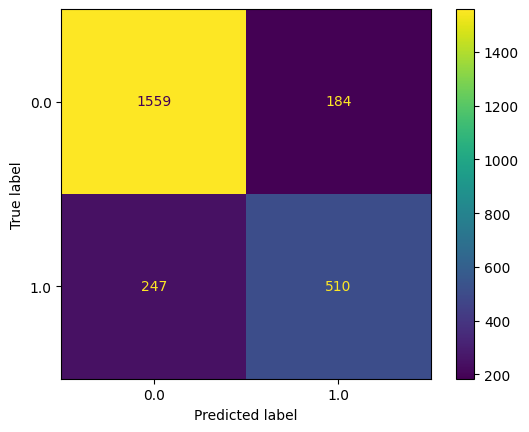

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test,model3_test_preds)

In [83]:
model3.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [84]:
model3_params = {'penalty': ['l2','l1',None,'elasticnet'],
                 'solver': ['lbfgs','liblinear','sag','saga','newton-cg','newton-cholesky'],
                 'C':[00.1,0.1,1,10,100]}

model3_grid = GridSearchCV(model3,model3_params)
model3_grid.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', None, 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga',
                                    'newton-cg', 'newton-cholesky']})

In [85]:
best_model3 = model3_grid.best_estimator_
best_model3_train_preds = best_model3.predict(X_train)
best_model3_test_preds = best_model3.predict(X_test)
print("The classification report of the train set :")
print(classification_report(y_train,best_model3_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_model3_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      5124
         1.0       0.77      0.72      0.74      2376

    accuracy                           0.84      7500
   macro avg       0.82      0.81      0.81      7500
weighted avg       0.84      0.84      0.84      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      1743
         1.0       0.77      0.74      0.76       757

    accuracy                           0.85      2500
   macro avg       0.83      0.82      0.83      2500
weighted avg       0.85      0.85      0.85      2500



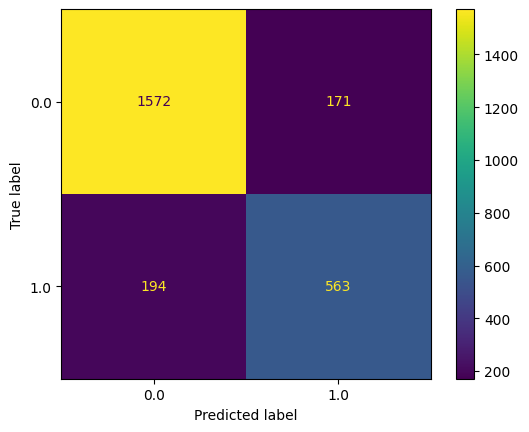

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test,best_model3_test_preds)

In [87]:
# i will try the same model but with the data transformed with pca .
model33 = LogisticRegression()
model33.fit(X_train_pca,y_train)
model33_train_preds = model33.predict(X_train_pca)
model33_test_preds = model33.predict(X_test_pca)
print("The classification report of the train set :")
print(classification_report(y_train,model33_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,model33_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      5124
         1.0       0.41      0.40      0.40      2376

    accuracy                           0.63      7500
   macro avg       0.57      0.56      0.56      7500
weighted avg       0.62      0.63      0.62      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74      1743
         1.0       0.41      0.40      0.41       757

    accuracy                           0.64      2500
   macro avg       0.58      0.57      0.58      2500
weighted avg       0.64      0.64      0.64      2500



In [88]:
model33_params = {'penalty': ['l2','l1',None,'elasticnet'],
                 'solver': ['lbfgs','liblinear','sag','saga','newton-cg','newton-cholesky'],
                 'C':[00.1,0.1,1,10,100]}

model33_grid = GridSearchCV(model33,model33_params)
model33_grid.fit(X_train_pca,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', None, 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga',
                                    'newton-cg', 'newton-cholesky']})

In [89]:
best_model33 = model33_grid.best_estimator_
best_model33_train_preds = best_model33.predict(X_train_pca)
best_model33_test_preds = best_model33.predict(X_test_pca)
print("The classification report of the train set :")
print(classification_report(y_train,best_model33_train_preds))
print("The classification report of the test set :")
print(classification_report(y_test,best_model33_test_preds))

The classification report of the train set :
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      5124
         1.0       0.00      0.00      0.00      2376

    accuracy                           0.68      7500
   macro avg       0.34      0.50      0.41      7500
weighted avg       0.47      0.68      0.55      7500

The classification report of the test set :
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82      1743
         1.0       0.00      0.00      0.00       757

    accuracy                           0.70      2500
   macro avg       0.35      0.50      0.41      2500
weighted avg       0.49      0.70      0.57      2500



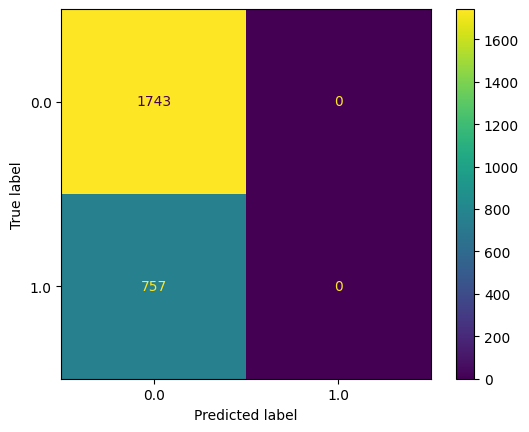

In [90]:
ConfusionMatrixDisplay.from_predictions(y_test,best_model33_test_preds)

For this third model i used the Logistic Regression :

After tuning with GridSearchCV the result was : F_score(0.90/0.76) , Recall(0.9/0.74) and with 0.85 as accuracy

With PCA the model didn't have a good performance with 0.7 as accuracy .

# Conclusion :
I will choose for this type of data the model3(LogisticRegression) after tuning with GridSearchCV and without PCA .